In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
import h5py
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
np.random.seed(1234)
from keras.utils import plot_model
import keras.backend.tensorflow_backend as Kback
from IPython.display import clear_output
import keras as K
import tensorflow as tf
import scipy.io as sio
from scipy import stats
import scipy as scp
import keras
from keras.backend.tensorflow_backend import set_session
import os
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#Load data
f = h5py.File('cropped.mat')

In [3]:
#input_parameters
hrz = 40
vrt = 40
x_train = {}
x_train_small_pre = np.ndarray((14114,hrz,vrt,3),int)
x_train_small = np.ndarray((14114,hrz,vrt,3),int)
x_train = f['bigdata'][()]
print(x_train.shape)


(3, 210, 165, 14114)


In [4]:
x_train_s = np.swapaxes(x_train,0,3)
x_train_s = np.swapaxes(x_train_s,1,2)
print(x_train.shape)
for j in range(0,x_train_s.shape[0]):
    pic = scp.misc.imresize(x_train_s[j,:,:],(hrz,vrt,3))
    x_train_small_pre[j,:,:] = pic 

(3, 210, 165, 14114)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(14114, 40, 40, 3)
(40, 40, 3)
163


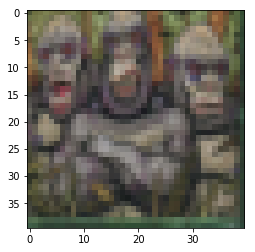

In [5]:
print(x_train_small_pre.shape)
probe = random.randint(0,14114)
testpic = x_train_small_pre[probe,:,:,:]
print(testpic.shape)
plt.imshow(testpic.astype(np.uint8)) 
print(max(testpic[:,0,0]))

0.35294117647058826
0.14901960784313725
90.0
38.0


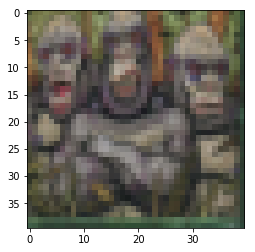

In [6]:
x_train_small = x_train_small_pre/255

testpic_sml = x_train_small[probe,:,:,:]
print(max(testpic_sml[:,0,2]))
print(min(testpic_sml[:,0,2]))

testpic = (x_train_small[probe,:,:,:]*255)
print(max(testpic[:,0,2]))
print(min(testpic[:,0,2]))
plt.imshow(testpic.astype(np.uint8)) 

In [22]:
class DCGAN():
    def __init__(self,param):
        with Kback.tf.device('/gpu:0'):
            self.img_rows =hrz
            self.img_cols = vrt
            self.channels = 3
            self.img_shape = (self.img_rows,self.img_cols,self.channels)
            self.latent_dim = 400
            learning_rate = 10**-3 #5
            optimizer = Adam(lr = learning_rate,beta_1 = 0.9, beta_2 = 0.999) 
            #d_optimizer = Adam(lr = learning_rate,beta_1 = 0.9, beta_2 = 0.999) 
            
            self.discriminator = self.build_discriminator(int(param[0]))
            self.discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
            self.discriminator.summary
            self.generator = self.build_generator(int(param[1]))

            z = Input(shape=(self.latent_dim,))
            img = self.generator(z)

            self.discriminator.trainable = False

            valid = self.discriminator(img)

            self.combined = Model(z,valid)
            self.combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)
            
        
    #Build Discriminator
    def build_discriminator(self,depth):
        dropout = 0.3 #0.5
        input_shape = (hrz,vrt,3)

        discriminator_model = Sequential(name='discriminator')

        discriminator_model.add(Conv2D(depth*1,kernel_size =  3, strides=1,input_shape = input_shape, padding ='same'))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))
        discriminator_model.add(Dropout(dropout))

        
        discriminator_model.add(Conv2D(depth*2,kernel_size = 3,strides=1, padding ='same'))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))
        discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Conv2D(depth*4,kernel_size = 3,strides=1, padding ='same'))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))
        discriminator_model.add(Dropout(dropout))
        
        discriminator_model.add(Flatten())
        discriminator_model.add(Dense(1))
        discriminator_model.add(Activation('sigmoid'))
        return discriminator_model
    
    #Build generator
    def build_generator(self,depth):
        #depth = 32
        dropout  = 0.3 #0.5
        dim = 5
        
        generator_model = Sequential(name='generator')

        generator_model.add(Dense(depth*4*dim*dim,input_dim=self.latent_dim))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(Activation("tanh"))
        generator_model.add(Reshape((dim,dim,depth*4)))
        generator_model.add(UpSampling2D())
        
        generator_model.add(Conv2D(depth*2,kernel_size = 8,padding = 'same'))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(Activation("tanh"))
        generator_model.add(UpSampling2D())

        generator_model.add(Conv2D(depth*1,kernel_size = 3,padding = 'same'))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(Activation("tanh"))
        generator_model.add(UpSampling2D())

        generator_model.add(Conv2D(self.channels,kernel_size = 3,padding = 'same'))
        generator_model.add(Activation("sigmoid"))

        noise = Input(shape = (self.latent_dim,))
        img = generator_model(noise)
        return generator_model

In [23]:
#Training
epochs = 500
batch_size = 64
d_losses = np.ones([epochs,2])
g_losses = np.ones([epochs,2])

In [24]:
#tRAINING
loopits = 1;
param = np.ones([2,loopits])
fake_samples =  np.ones([loopits,4,hrz,vrt,3])
trajec_fake_samples =  np.ones([loopits,epochs,hrz,vrt,3])
scl = 8;
param[0][:] = [scl*1] #discriminator
param[1][:] = [scl*1] #generator

d_losses = np.ones([loopits,epochs,2])
g_losses = np.ones([loopits,epochs,2])
sample_ind = 0
for looper in range(loopits):
    DCGAN_model = DCGAN(param[:,looper])
    DCGAN_model.generator.summary()
    DCGAN_model.discriminator.summary()

    noise = np.random.normal(0,1.0, (int(batch_size/2),DCGAN_model.latent_dim))
    gen_imgs = DCGAN_model.generator.predict(noise)

    yones = np.ones([batch_size,1])

    y = np.ones([batch_size,1])
    y[int(batch_size/2):,:]=0

    for epoch in range(epochs):
        clear_output(wait=True)
        print(looper)
        print(epoch)
        idx = np.random.randint(0,x_train.shape[0],int(batch_size/2))
        imgs = x_train_small[idx]

        noise = np.random.normal(0,1.0, (int(batch_size/2),DCGAN_model.latent_dim))
        gen_imgs = DCGAN_model.generator.predict(noise)
        x = np.concatenate([imgs,gen_imgs])

        d_losses[looper,epoch,:] = DCGAN_model.discriminator.train_on_batch(x,y)

        noise = np.random.normal(0,1.0, (batch_size,DCGAN_model.latent_dim))
        g_losses[looper,epoch,:] = DCGAN_model.combined.train_on_batch(noise,yones)
        
        if epoch%100 == 0:
            noise = np.random.normal(-1.0,1.0, size=[batch_size,DCGAN_model.latent_dim])
            sample = DCGAN_model.generator.predict(noise)
            trajec_fake_sample = (np.squeeze(sample[1,:,:,:]))  
            trajec_fake_samples[looper,sample_ind,:,:,:] = trajec_fake_sample
            sample_ind = sample_ind+1
    #evaluate

    for sample in range(4):
        
        noise = np.random.normal(-1.0,1.0, size=[batch_size,DCGAN_model.latent_dim])
        images_good_fake = DCGAN_model.generator.predict(noise)
        fake_sample = (np.squeeze(images_good_fake[1,:,:,:]))  
        fake_samples[looper,sample,:,:,:] = fake_sample


0
499


[0.34125522 0.43591669 0.35194367]


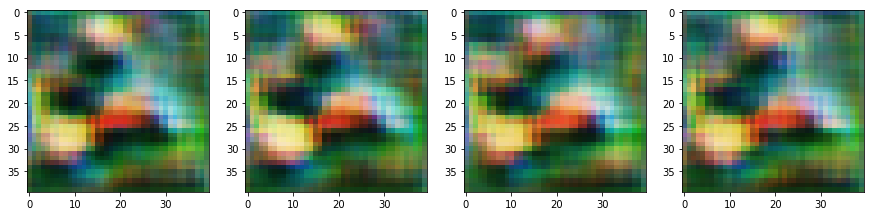

In [25]:
width = 15
height = 15
plt.figure(figsize=(width,height))
scale = 1;
plotcounter = 1;

noise = np.random.uniform(-1.0,1.0, size=[batch_size,DCGAN_model.latent_dim])

print(fake_samples[0,0,0,0])
fake_samples_scaled = fake_samples

for looper in range(loopits):
 
    plt.subplot(loopits,4,plotcounter)
    plt.imshow(fake_samples_scaled[looper,0,:,:])
    plt.subplot(loopits,4,plotcounter+1)
    plt.imshow(fake_samples_scaled[looper,1,:,:])
    plt.subplot(loopits,4,plotcounter+2)
    plt.imshow(fake_samples_scaled[looper,2,:,:])
    plt.subplot(loopits,4,plotcounter+3)
    plt.imshow(fake_samples_scaled[looper,3,:,:])
    plotcounter = plotcounter+4

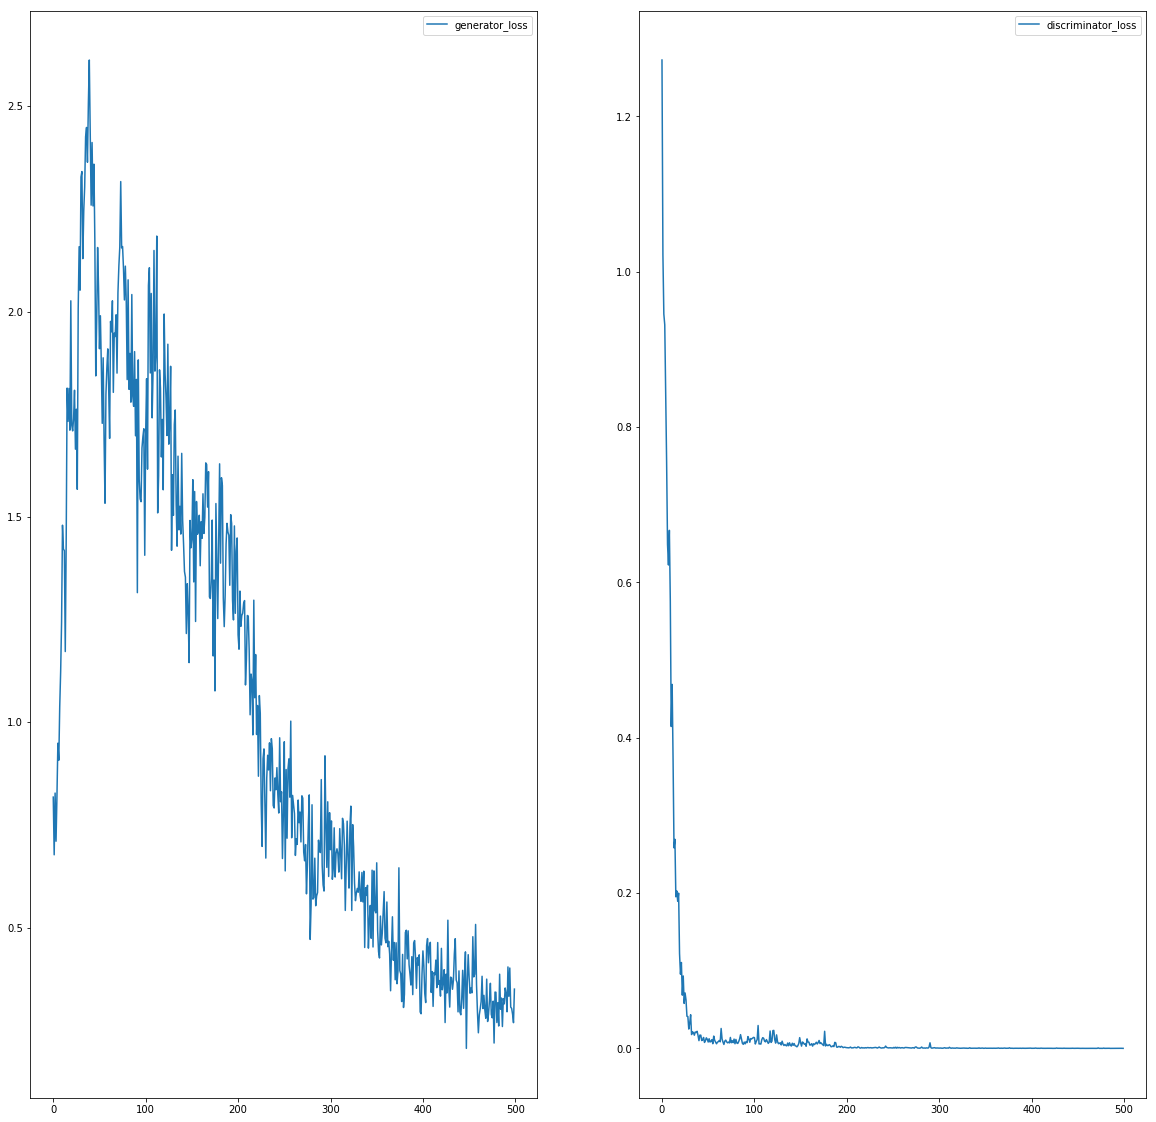

In [26]:
width = 20
height = 20
plt.figure(figsize=(width,height))
plt.subplot(1,2,1)
g_losses_plot = np.swapaxes(g_losses,0,1)
plt.plot(g_losses_plot[:,:,0],label='generator_loss')
plt.legend()
plt.subplot(1,2,2)
d_losses_plot = np.swapaxes(d_losses,0,1)
plt.plot(d_losses_plot[:,:,0] ,label='discriminator_loss')
#plt.ylim((0,0.002))
plt.legend()
#plt.subplot(1,3,2)
#plt.plot(g_losses[:,1],label='generator')
#plt.plot(d_losses[:,1] ,label='discriminator')
#plt.legend()

(1, 100, 40, 40, 3)
1.0
0.25


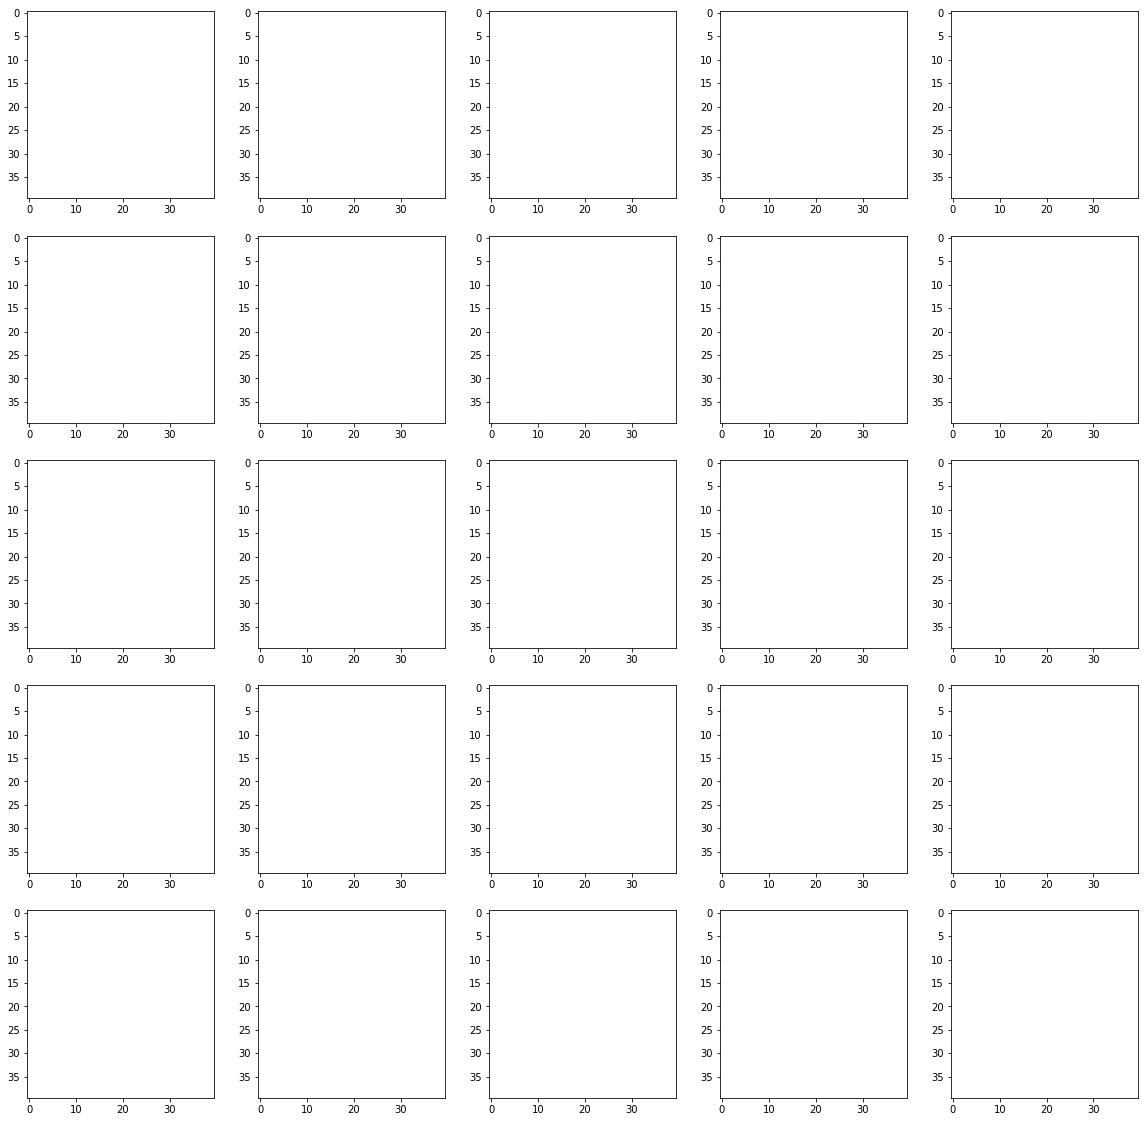

In [12]:
ntwrk = 0;
width = 20
height = 20
plt.figure(figsize=(width,height))
print(trajec_fake_samples.shape)
print(epochs/100)
print(epochs/100/4)
trajec_fake_samples_scaled = (trajec_fake_samples)
next = 0
for looper in range(0,500,round(500/25)):
    next = next+1
    plt.subplot(5,5,next)
    #plt.imshow(trajec_fake_samples_scaled[ntwrk,looper,:,:,:])
    plt.imshow(trajec_fake_samples_scaled[0,10,:,:,:])